In [1]:
# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [2]:
import numpy as np
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

In [3]:
class Arm(composer.Entity):
    """A multi-legged creature derived from `composer.Entity`."""
    def _build(self, ctrl_type="position", type=0):
        self._model = mjcf.from_path('scene.xml')
        self._arm_jnts = [self._model.find_all('joint')[i] for i in [0,1,2,3,4,5,6]]
        self._whip_start = self._model.find('geom', 'whip_start')
        self._whip_end = self._model.find('site', 'whip_end')
        self._acts = self._model.find_all('actuator')

    def _build_observables(self):
        return Arm_Observables(self)
    
    @property
    def mjcf_model(self):
        return self._model
    
    @property
    def arm_jnts(self):
        return tuple(self._arm_jnts)
    
    @property
    def whip_start(self):
        return self._whip_start
    
    @property
    def whip_end(self):
        return self._whip_end
    
    @property
    def actuators(self):
        return tuple(self._acts)

class Arm_Observables(composer.Observables):
    """Observables for the Arm_Whip entity. The self._entity is the given composer.Entity class"""
    @composer.observable
    def arm_jnts_qpos(self):
        return observable.MJCFFeature('qpos', self._entity.arm_jnts)
    
    @composer.observable
    def whip_start_xpos(self):
        return observable.MJCFFeature('xpos', self._entity.whip_start)

    @composer.observable
    def whip_end_xpos(self):
        return observable.MJCFFeature('xpos', self._entity.whip_end)

In [4]:
class Arm_Observables(composer.Observables):
    """Observables for the Arm_Whip entity. The self._entity is the given composer.Entity class"""
    @composer.observable
    def arm_jnts_qpos(self):
        return observable.MJCFFeature('qpos', self._entity.arm_jnts)
    
    @composer.observable
    def whip_start_xpos(self):
        return observable.MJCFFeature('xpos', self._entity.whip_start)

    @composer.observable
    def whip_end_xpos(self):
        return observable.MJCFFeature('xpos', self._entity.whip_end)

In [5]:

class RandomPos(variation.Variation):
    """A uniformly sampled position for the object."""
    def __init__(self, radius, height):
        self._radius = radius
        self._height = height
        self._heading = distributions.Uniform(0, 2*np.pi)

    def __call__(self, initial_value=None, current_value=None, random_state=None):
        radius, heading, height = variation.evaluate(
            (self._radius, self._heading, self._height), random_state=random_state)
        return (radius*np.cos(heading), radius*np.sin(heading), height)


class MyTask(composer.Task):
    def __init__(self, 
                 jnt_qpos=None, 
                 action_mask=None,
                 max_steps=None,
                 max_time = 0.5,
                 gamma=1e-1,):
        self._arm = Arm()
        self._whip_end = self._arm._whip_end

        self._mjcf_variator = variation.MJCFVariator()       # An instance of this class remembers the original value of each MJCF attribute the first time a variation is applied. The original value is then passed as an argument to each variation callable.
        self._physics_variator = variation.PhysicsVariator() # An instance of this class remembers the original value of each attribute the first time a variation is applied. The original value is then passed as an argument to each variation callable.

        self._jnt_qpos = jnt_qpos
        self._action_mask = np.ones(7) if action_mask is None else action_mask

        self.tgt_height = distributions.Uniform(1, 1.5)
        self.tgt_radius = distributions.Uniform(1, 1.5) 

        self._arm.observables.arm_jnts_qpos.enabled = True
        self._arm.observables.whip_start_xpos.enabled = True
        self._arm.observables.whip_end_xpos.enabled = True

        self._task_observables = {}
        self._task_observables['distance'] = observable.Generic(lambda physics: self._distance_min)
        self._task_observables['time'] = observable.Generic(lambda physics: self._get_time)

        self._task_observables = {}
        for obs in self._task_observables.values():
            obs.enabled = True

        self._gamma = gamma # 额外奖励(时间奖励)的系数
        self._max_steps = max_steps
        self._distance_buffer = []
        self._min_distance = 1e3
        self._min_time = 1e3
        self._max_time = max_time # episode must be terminated within this time
        self._episode_counter = 0

    @property
    def root_entity(self):
        return self._arm

    @property
    def task_observables(self):
        return self._task_observables

    @property
    def max_steps(self):
        return self._max_time / self.control_timestep
    
    @property
    def episode_counter(self):
        return self._episode_counter
    
    # ----------自定义函数----------  
    def _distance(self, physics):
        # target_pos, _ = self._target.get_pose(physics) # a world-frame position
        source = self._arm._whip_end
        source_xpos = physics.bind(source).xpos # a world-frame position
        return np.linalg.norm((source_xpos, self._target_xpos), ord = 2)
    
    def _initialize_arm_qpos(self, physics, random_state):
        if self._jnt_qpos is not None:
            rand_jnt_qpos = self._jnt_qpos * self._action_mask
        else:
            spec = self.action_spec(physics)
            random = np.random if random_state is None else random_state
            rand_jnt_qpos = random.uniform(
                    low=spec.minimum * 0.8,
                    high=spec.maximum * 0.8,
                    ).astype(spec.dtype, copy=False) * self._action_mask
        print(f'Episode-{self._episode_counter}: ', rand_jnt_qpos)
        physics.bind(self._arm._arm_jnts).qpos = rand_jnt_qpos

    # ----------重写回调函数----------
    def initialize_episode_mjcf(self, random_state):
        # The Environment calls this method and recompiles the physics if necessary before calling initialize_episode.
        self._mjcf_variator.apply_variations(random_state)
        
    def initialize_episode(self, physics, random_state):
        # Environment calls this method after initialize_episode_mjcf, and also after the physics has been recompiled if necessary.
        self._physics_variator.apply_variations(physics, random_state)
        self._step_counter = 0
        self._episode_counter += 1
        self._max_steps = self._max_time / self.control_timestep
        self._target_xpos = RandomPos(self.tgt_radius, self.tgt_height)(random_state=random_state)
        self._initialize_arm_qpos(physics, random_state)

    def before_step(self, physics, action, random_state):
        self._distance_buffer = []
        self._substep_counter = 0

    def after_substep(self, physics, random_state):
        distance = self._distance(physics)
        self._distance_buffer.append(distance)
        self._substep_counter += 1
        
    def after_step(self, physics, random_state): # 这一次after_step之后才会更新substep循环内的最后一次的观测值
        self._min_time = np.argmin(self._distance_buffer)
        self._min_distance = self._distance_buffer[self._min_time]
        self._step_counter += 1

    def get_reward(self, physics): 
        # calculate distance reward and time reward
        basic = 1.0 / (self._min_distance + 1e-6)
        bonus = 1.0 / (self._min_time + 1e-6)
        sigmoid_reward = 1.0 / (1 + np.exp(-basic-self._gamma*bonus))
        return sigmoid_reward
    
    def should_terminate_episode(self, physics):
        if self._step_counter >= self._max_steps:
            return True
        else:
            return False

In [6]:
task = MyTask()

Episode-1:  [ 0.   -1.76  0.    0.    0.    3.75  0.  ]


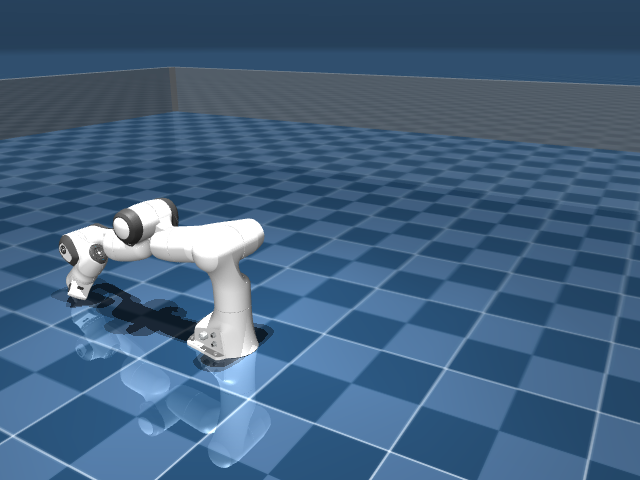

In [7]:
jnt_qpos = np.array([0, -1.76, 0, 0, 0, 3.75, 0])
task = MyTask(jnt_qpos)
env = composer.Environment(task, random_state=np.random.RandomState(42))
env.reset()
PIL.Image.fromarray(env.physics.render(height=480, width=640))

# Sampling

## Fixed Gesture

Load in jupyter notebook

In [ ]:

# Simulate episode with random actions
duration = 2 # Seconds
frames = []
ticks = []
rewards = []
observations = []

control_timestep, physics_timestep = 0.5, 0.002
jnt_qpos = np.array([0, -1.76, 0, 0, 0, 3.75, 0])
action_mask = np.array([1, 1, 0, 1, 0, 1, 0])
task = MyTask(jnt_qpos, action_mask)
task.set_timesteps(control_timestep, physics_timestep)
env = composer.Environment(task, duration, np.random.RandomState(42))
env.reset()
time_step = env.reset() # dm_env._environment.TimeStep
action_spec = env.action_spec()
fixed_action = [0, -0.63, 0, -2.67, 0, 1.66, 0]


while env.physics.data.time < duration:
    time_step = env.step(fixed_action)
    rewards.append(time_step.reward)
    observations.append(copy.deepcopy(time_step.observation))
    ticks.append(env.physics.data.time)
    if len(frames) < env.physics.data.time / env.control_timestep():
        camera0 = env.physics.render(height=400, width=400)
        frames.append(camera0)

video = display_video(frames, framerate=1./env.control_timestep())
video

Show trajectory of the whip

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


(2, 1)

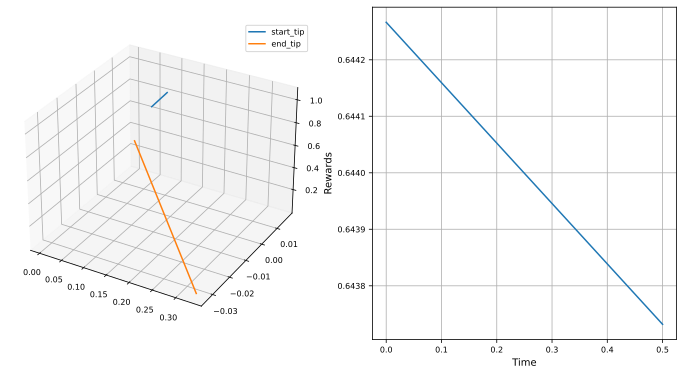

In [110]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

start_tip = np.array([obs['whip_start_xpos'] for obs in observations]).squeeze().T
end_tip = np.array([obs['whip_end_xpos'] for obs in observations]).squeeze().T
rewards = np.array(rewards).squeeze()

fig = plt.figure(figsize=(12, 6))
canvas = FigureCanvas(fig)
ax = fig.add_subplot(121, projection='3d')
ax.plot(start_tip[0], start_tip[1], start_tip[2], label="start_tip")  # Plot contour curves
ax.plot(end_tip[0], end_tip[1], end_tip[2], label="end_tip")  # Plot contour curves
ax.legend()
ax1 = fig.add_subplot(122)
times = np.arange(len(rewards)) * env.control_timestep()
ax1.plot(times,rewards,label="rewards")
ax1.grid()
ax1.set_xlabel("Time"); ax1.set_ylabel("Rewards")

env._hooks._episode_step_count, task._episode_counter

View the environment in a window

In [ ]:
from dm_control import viewer
import numpy as np

env = composer.Environment(task, random_state=np.random.RandomState(42))
action_spec = env.action_spec()
fixed_action = [0, -0.63, 0, -2.67, 0, 1.66, 0]
# Define a uniform random policy.
def fixed_policy(time_step):
  del time_step  # Unused.
  return fixed_action

# Launch the viewer application.
viewer.launch(env, policy=fixed_policy)

## Random Gesture

In [66]:
def sample_random_action(env, mask = None):
    action = np.random.uniform(
        low=env.action_spec().minimum * 0.7,
        high=env.action_spec().maximum * 0.7,
        ).astype(env.action_spec().dtype, copy=False)
    if mask is not None:
        action *= mask
    return action

In [89]:
import copy
np.set_printoptions(precision=2)
# Simulate episode with random actions
max_episode = 5
frames = []
rewards = []
observations = []
ticks = []

control_timestep, physics_timestep = 0.005, 0.005
jnt_qpos = np.array([0, -1.76, 0, 0, 0, 3.75, 0])
action_mask = np.array([1, 1, 0, 1, 0, 1, 0])
task = MyTask(jnt_qpos, action_mask, max_time=2)
task.set_timesteps(control_timestep, physics_timestep)
env = composer.Environment(task) # random_state=np.random.RandomState(42)

action_spec = env.action_spec()

actions = [sample_random_action(env, mask=[1, 1, 0, 1, 0, 1, 0])for _ in range(max_episode)]

while env.task.episode_counter < max_episode:
    time_step = env.step(actions[env.task.episode_counter])
    rewards.append(time_step.reward)
    observations.append(copy.deepcopy(time_step.observation))
    ticks.append(env.physics.data.time)
    if (len(frames) % env.task.max_steps)\
        < (env.physics.data.time / env.control_timestep()):
        camera0 = env.physics.render(height=400, width=400)
        frames.append(camera0)

display_video(frames, framerate=1./env.control_timestep())

Episode-1:  [ 0.   -1.76  0.    0.    0.    3.75  0.  ]
Episode-2:  [ 0.   -1.76  0.    0.    0.    3.75  0.  ]
Episode-3:  [ 0.   -1.76  0.    0.    0.    3.75  0.  ]
Episode-4:  [ 0.   -1.76  0.    0.    0.    3.75  0.  ]
Episode-5:  [ 0.   -1.76  0.    0.    0.    3.75  0.  ]


: 

observations

In [145]:
len(observations), env.task._episode_counter

(44, 22)

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

start_tip = np.array([obs['whip_start_xpos'] for obs in observations]).squeeze().T
end_tip = np.array([obs['whip_end_xpos'] for obs in observations]).squeeze().T
rewards = np.array(rewards).squeeze()

fig = plt.figure(figsize=(12, 6))
canvas = FigureCanvas(fig)
ax = fig.add_subplot(121, projection='3d')
ax.plot(start_tip[0], start_tip[1], start_tip[2], label="start_tip")  # Plot contour curves
ax.plot(end_tip[0], end_tip[1], end_tip[2], label="end_tip")  # Plot contour curves
ax.legend()
ax1 = fig.add_subplot(122)
times = np.arange(len(rewards)) * env.control_timestep()
ax1.plot(times,rewards,label="rewards")
ax1.grid()
ax1.set_xlabel("Time"); ax1.set_ylabel("Rewards")

In [ ]:
from dm_control import viewer
import numpy as np

env = composer.Environment(task, random_state=np.random.RandomState(42))
action_spec = env.action_spec()
random_action = sample_random_action(env, mask=[0, 1, 0, 1, 0, 1, 0])
# Define a uniform random policy.
def random_policy(time_step):
  del time_step  # Unused.
  return random_action

# Launch the viewer application.
viewer.launch(env, policy=random_policy)